# Librerías

In [1]:
#Librerías Base
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.colab import drive

In [2]:
#Librerías de Métricas
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import scale

In [3]:
#Librerías de Machine Learning
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam, Adagrad, RMSprop

# Conexión al repositorio de datos

In [4]:
#Accedemos a Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# Calibraciones

In [5]:
#Cantidad de iteraciones en el entrenamiento
numero_de_iteraciones_al_entrenar = 10

In [6]:
#Calibración del learning rate
calibracion_lr = [0.01, 0.05, 0.1, 0.5]

#Valor óptimo
lr_calibrado = 0

In [7]:
#Calibración del tamaño de batch
calibracion_batch = [16, 32, 64, 128]

#Valor óptimo
batch_calibrado = 0

In [8]:
#Calibración de optimizador
calibracion_optimizador = [
'SGD(learning_rate=0.5)',
'SGD(learning_rate=0.5, momentum=0.3)',
'SGD(learning_rate=0.5, momentum=0.3, nesterov=True)',  
'Adam(learning_rate=0.5)',
'Adagrad(learning_rate=0.5)',
'RMSprop(learning_rate=0.5)'
]

#Valor óptimo
optimizador_calibrado = 0

# Funciones utilitarias

In [9]:
#Vamos a crear una función utilitaria para obtener el dataframe con los "accuracy" y "loss"
def obtener_df_loss_accuracy(array_calibracion, descripcion_calibracion, array_descripciones):
  #Fusionaremos uno tras otro para crear un único registro
  #Recordemos que al usar "axis = 1" estamos fusionandolas filas
  dfDescripcion = pd.concat(array_descripciones, axis = 1)

  #A cada "loss" y "accuracy" vamos a agregarle por encima su lr
  #Obtenemos el primer elemento del array de dataframes para obtener los títulos de las columnas
  columnas_loss_accuracy = array_descripciones[0].columns

  #Vamos a crear nuevas columnas a nuestro dataframe
  #Primero colocaremos las columnas que tendrán el nombre de cada lr usado, estos valores están en "array_lr"
  #Luego, para cada "descripcion_calibracion" vamos a colocarle las columnas "columnas_loss_accuracy"
  #Estas son columnas anidadas, las podemos crear con la función "MultiIndex" de Pandas
  #Por último, con el parámetro "names" colocamos el nombre para cada agrupación de columnas
  nuevas_columnas = pd.MultiIndex.from_product(
    [array_calibracion, columnas_loss_accuracy],
    names=[descripcion_calibracion, 'metricas']
  )

  #Colocamos las nuevas columnas a nuestro dataframe
  dfDescripcion.columns = nuevas_columnas
  dfDescripcion

  #Vamos a crear el dataframe de "loss"
  #Usaremos la función "xs" que nos permite navegar en un dataframe con índices complejos y extraer los campos que queremos
  #En la función "xs" definimos:
  # 1. El campo que queremos consultar (loss)
  # 2. De qué subconjunto de campos queremos consultar (level = 'metricas')
  # 3. Cómo queremos extraer la data (axis = 1, queremos extraerla como columnas)
  dfLoss = dfDescripcion.xs('loss', level = 'metricas', axis = 1)
  
  #Vamos a crear el dataframe de "accuracy"
  #Usaremos la función "xs" que nos permite navegar en un dataframe con índices complejos y extraer los campos que queremos
  #En la función "xs" definimos:
  # 1. El campo que queremos consultar (accuracy)
  # 2. De qué subconjunto de campos queremos consultar (level = 'metricas')
  # 3. Cómo queremos extraer la data (axis = 1, queremos extraerla como columnas)
  dfAccuracy = dfDescripcion.xs('accuracy', level = 'metricas', axis = 1)
  dfAccuracy

  #Devolvemos los dataframes
  return dfLoss, dfAccuracy

# Lectura de datos

In [10]:
#Leemos el dataset
df = pd.read_csv('/content/drive/MyDrive/Data/diabetes.csv')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [11]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

# Definición de "features"

In [12]:
#Seleccionamos las columnas con las que trabajaremos
x = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']].values
x

array([[  6.   , 148.   ,  72.   , ...,  33.6  ,   0.627,  50.   ],
       [  1.   ,  85.   ,  66.   , ...,  26.6  ,   0.351,  31.   ],
       [  8.   , 183.   ,  64.   , ...,  23.3  ,   0.672,  32.   ],
       ...,
       [  5.   , 121.   ,  72.   , ...,  26.2  ,   0.245,  30.   ],
       [  1.   , 126.   ,  60.   , ...,  30.1  ,   0.349,  47.   ],
       [  1.   ,  93.   ,  70.   , ...,  30.4  ,   0.315,  23.   ]])

# Escalamiento de "Features"

In [14]:
#Importamos la librería para escalar
from sklearn.preprocessing import scale

#Escalamos
x = scale(x)
x

array([[ 0.63994726,  0.84832379,  0.14964075, ...,  0.20401277,
         0.46849198,  1.4259954 ],
       [-0.84488505, -1.12339636, -0.16054575, ..., -0.68442195,
        -0.36506078, -0.19067191],
       [ 1.23388019,  1.94372388, -0.26394125, ..., -1.10325546,
         0.60439732, -0.10558415],
       ...,
       [ 0.3429808 ,  0.00330087,  0.14964075, ..., -0.73518964,
        -0.68519336, -0.27575966],
       [-0.84488505,  0.1597866 , -0.47073225, ..., -0.24020459,
        -0.37110101,  1.17073215],
       [-0.84488505, -0.8730192 ,  0.04624525, ..., -0.20212881,
        -0.47378505, -0.87137393]])

# Definición de "labels"

In [15]:
#Definimos los labels
y = df['Outcome'].values
y

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,

# División de los datos en datos de entrenamiento (x_train, y_train) y datos de validación (x_test, y_test)

In [16]:
#Dividimos los datos en datos de entrenamiento (x_train, y_train) y datos de validación (x_test, y_test)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [17]:
#Features de entrenamiento
x_train

array([[-0.84488505, -0.81042491, -0.16054575, ..., -1.57285666,
        -0.4164028 , -0.70119842],
       [-0.54791859,  0.03459802,  0.35643175, ...,  0.49592704,
         0.03359489, -0.61611067],
       [-0.84488505,  2.44447821,  0.35643175, ...,  1.38436175,
         2.784923  , -0.95646168],
       ...,
       [-0.84488505, -0.77912776, -0.26394125, ...,  0.15324507,
        -0.55230814, -1.04154944],
       [-1.14185152,  0.53535234, -3.57259724, ...,  0.54669473,
         1.39264829, -0.70119842],
       [-0.84488505,  0.81702665,  1.28699125, ...,  2.19664492,
        -0.34391995, -0.53102292]])

In [18]:
#Labels de entrenamiento
y_train

array([0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [19]:
#Features de validación
x_test

array([[ 0.63994726,  1.38037527, -0.05715025, ...,  0.20401277,
         0.48057245,  1.34090765],
       [-0.54791859, -0.68523633, -3.57259724, ..., -1.24286663,
        -1.09894962, -0.87137393],
       [-0.25095213,  1.63075243,  0.77001375, ...,  0.47054319,
        -0.64593181, -0.95646168],
       ...,
       [ 1.23388019, -0.65393918,  0.35643175, ...,  0.85130092,
        -0.85129988,  0.74529338],
       [ 1.82781311, -0.84172205,  0.14964075, ..., -1.1286393 ,
         0.37184818,  1.93652192],
       [ 2.42174604, -0.46615631,  0.56322275, ..., -1.06517968,
        -1.01136617,  0.91546889]])

In [20]:
#Labels de validación
y_test

array([0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Configuración del modelo

In [88]:
#Crearemos una función que construya la red neuronal
def definicion_red_neuronal():
  #Instaciamos un modelo de machine learning vacío con "Sequential"
  model = Sequential()

  #Creamos la red neuronal
  #En la primera neurona verificamos si le hemos enviado un inicializador
  model.add(Dense(1, input_shape=(8,), activation='sigmoid'))

  return model

# Calibracion de Learning Rate

In [89]:
#Creamos un array en donde guardaremos las descripciones de cada entrenamiento
array_descripciones = []

#Iteramos cada calibración
for lr in calibracion_lr:
  #Obtenemos la red neuronal
  model = definicion_red_neuronal()

  #Agregamos el "lr" de la calibración
  model.compile(
    loss='binary_crossentropy',
    optimizer=SGD(learning_rate=lr),
    metrics=['accuracy']
  )
  
  #Entrenamos la neurona
  #Para evitar que el output de entrenamiento se muestre en pantalla desactivamos la variable "verbose"
  descripcion_de_entrenamiento = model.fit(x_train, y_train, epochs = numero_de_iteraciones_al_entrenar, verbose=0)

  #Convertimos la descripción del entrenamiento en un dataframe
  df = pd.DataFrame(
      descripcion_de_entrenamiento.history,
      index = descripcion_de_entrenamiento.epoch
  )

  #Agregamos el dataframe a la lista de descripciones de entrenamiento
  array_descripciones.append(df)

In [90]:
#Obtenemos la evolucion del "loss" y el "accuracy"
dfLoss, dfAccuracy = obtener_df_loss_accuracy(calibracion_lr, 'lr', array_descripciones)

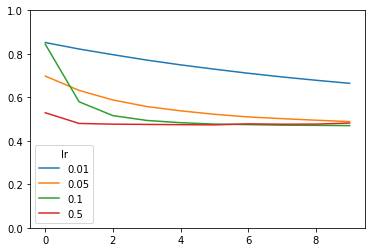

In [91]:
#Graficamos el dfLoss
dfLoss.plot(ylim=(0,1))

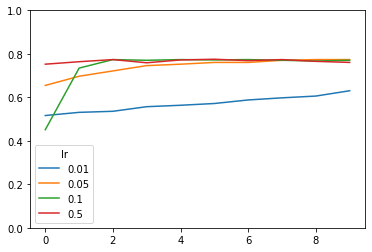

In [92]:
#Graficamos el dfLoss
dfAccuracy.plot(ylim=(0,1))

In [93]:
#NOS QUEDAMOS CON EL VALOR MÁS BAJO DEL LOSS O EL MÁS ALTO DEL ACCURACY
lr_calibrado = 0.05

# Calibración del Batch Size

In [95]:
#Creamos un array en donde guardaremos las descripciones de cada entrenamiento
array_descripciones = []

#Iteramos cada calibración
for batch in calibracion_batch:
  #Obtenemos la red neuronal
  model = definicion_red_neuronal()

  #Agregamos el "lr" de la calibración
  #En "lr" ya hemos calibrado su valor, sabemos que el valor de 0.5 es el indicado
  model.compile(
    loss='binary_crossentropy',
    optimizer=SGD(learning_rate=lr_calibrado),
    metrics=['accuracy']
  )
  
  #Entrenamos la neurona
  #En "batch_size" definimos el valor
  descripcion_de_entrenamiento = model.fit(x_train, y_train, epochs = numero_de_iteraciones_al_entrenar, batch_size=batch, verbose=0)

  #Convertimos la descripción del entrenamiento en un dataframe
  df = pd.DataFrame(
      descripcion_de_entrenamiento.history,
      index = descripcion_de_entrenamiento.epoch
  )

  #Agregamos el dataframe a la lista de descripciones de entrenamiento
  array_descripciones.append(df)

In [96]:
#Obtenemos la evolucion del "loss" y el "accuracy"
dfLoss, dfAccuracy = obtener_df_loss_accuracy(calibracion_batch, 'batch', array_descripciones)

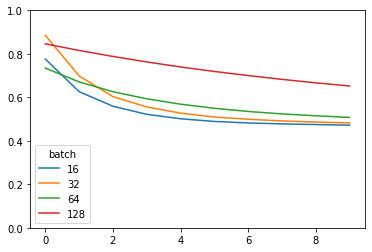

In [97]:
#Graficamos el dfLoss
dfLoss.plot(ylim=(0,1))

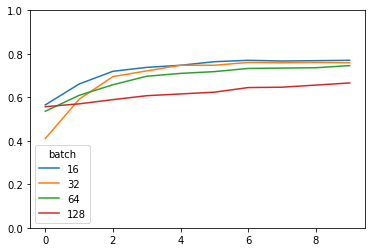

In [98]:
#Graficamos el dfLoss
dfAccuracy.plot(ylim=(0,1))

In [99]:
#NOS QUEDAMOS CON EL VALOR MÁS BAJO DEL LOSS O EL MÁS ALTO DEL ACCURACY
batch_calibrado = 32

# Calibración del optimizador

In [100]:
#Creamos un array en donde guardaremos las descripciones de cada entrenamiento
array_descripciones = []

#Iteramos cada calibración
for optimizador in calibracion_optimizador:
  #Obtenemos la red neuronal
  model = definicion_red_neuronal()
  
  #Agregamos el "lr" de la calibración
  #En "lr" ya hemos calibrado su valor, sabemos que el valor de 0.5 es el indicado
  model.compile(
    loss='binary_crossentropy',
    optimizer=eval(optimizador),
    metrics=['accuracy']
  )
  
  #Entrenamos la neurona
  #En "batch_size" colocamos 32, ya que fue lo que encontramos en la calibración anterior
  descripcion_de_entrenamiento = model.fit(x_train, y_train, epochs = numero_de_iteraciones_al_entrenar, batch_size=batch_calibrado, verbose=0)

  #Convertimos la descripción del entrenamiento en un dataframe
  df = pd.DataFrame(
      descripcion_de_entrenamiento.history,
      index = descripcion_de_entrenamiento.epoch
  )

  #Agregamos el dataframe a la lista de descripciones de entrenamiento
  array_descripciones.append(df)

In [101]:
#Obtenemos la evolucion del "loss" y el "accuracy"
dfLoss, dfAccuracy = obtener_df_loss_accuracy(calibracion_optimizador, 'optimizador', array_descripciones)

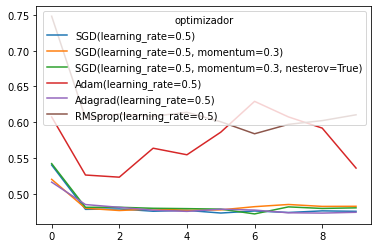

In [102]:
#Graficamos el dfLoss
dfLoss.plot()#ylim=(0,1))

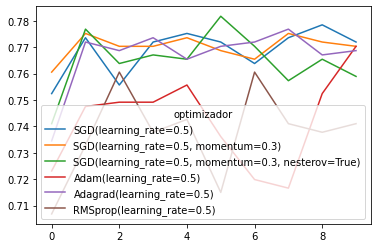

In [103]:
#Graficamos el dfLoss
dfAccuracy.plot()#ylim=(0,1))

In [104]:
#NOS QUEDAMOS CON EL VALOR MÁS BAJO DEL LOSS O EL MÁS ALTO DEL ACCURACY
optimizador_calibrado = SGD(learning_rate=0.5) #Adam(lr=0.5)

# Definicion del modelo

In [141]:
#Definimos el modelo con el inicializador calibrado
model = Sequential()

  #Creamos la red neuronal
  #En la primera neurona verificamos si le hemos enviado un inicializador
  #De aquí en adelante seguimos construyendo nuestra red neuronal
model.add(Dense(15, input_shape=(8,), activation='tanh'))
model.add(Dense(5, activation='tanh'))

  ### Esta es la capa de salida
model.add(Dense(1, activation='sigmoid'))



# Compilación del modelo

In [142]:
#Compilamos el modelo con el optimizador calibrado
model.compile(
  loss='binary_crossentropy',
  optimizer=optimizador_calibrado,
  metrics=['accuracy']
)

# Entrenamiento del modelo

In [143]:
#Entrenamos el modelo enviándole los features (x_train) y labels (y_train) de entrenamiento, con el batch calibrado
model.fit(x_train, y_train, epochs=numero_de_iteraciones_al_entrenar, batch_size=batch_calibrado)

Epoch 1/10
20/20 [==============================] - 0s 1ms/step - loss: 0.5491 - accuracy: 0.7231
Epoch 2/10
20/20 [==============================] - 0s 1ms/step - loss: 0.4815 - accuracy: 0.7736
Epoch 3/10
20/20 [==============================] - 0s 1ms/step - loss: 0.4822 - accuracy: 0.7687
Epoch 4/10
20/20 [==============================] - 0s 1ms/step - loss: 0.4686 - accuracy: 0.7752
Epoch 5/10
20/20 [==============================] - 0s 2ms/step - loss: 0.4601 - accuracy: 0.7850
Epoch 6/10
20/20 [==============================] - 0s 1ms/step - loss: 0.4677 - accuracy: 0.7834
Epoch 7/10
20/20 [==============================] - 0s 1ms/step - loss: 0.4488 - accuracy: 0.8013
Epoch 8/10
20/20 [==============================] - 0s 1ms/step - loss: 0.4573 - accuracy: 0.7818
Epoch 9/10
20/20 [==============================] - 0s 1ms/step - loss: 0.4449 - accuracy: 0.7850
Epoch 10/10
20/20 [==============================] - 0s 2ms/step - loss: 0.4429 - accuracy: 0.7883


# Accuracy de entrenamiento (patrones encontrados en la data)

In [144]:
#Con los features (x_train) que usamos para entrenar el modelo, realizamos las predicciones (y_train_prediccion)
y_train_prediccion = model.predict(x_train).ravel()
y_train_prediccion

array([0.03859657, 0.13009319, 0.908352  , 0.31270444, 0.7912448 ,
       0.7383649 , 0.03353867, 0.06117523, 0.02338818, 0.05413374,
       0.0314253 , 0.23842326, 0.1942234 , 0.20308185, 0.75528395,
       0.02576959, 0.05430564, 0.42371804, 0.0914526 , 0.65962917,
       0.37646335, 0.02851495, 0.04171428, 0.46983618, 0.04075092,
       0.71284014, 0.22984993, 0.03763032, 0.3967561 , 0.5777166 ,
       0.6255568 , 0.09184742, 0.93403286, 0.91675204, 0.89206487,
       0.02841458, 0.54971236, 0.19023976, 0.05527171, 0.03965124,
       0.08671597, 0.24120328, 0.04380029, 0.06619817, 0.22874478,
       0.38676876, 0.09089127, 0.14308459, 0.2798099 , 0.05125269,
       0.25279137, 0.06346729, 0.35359645, 0.5955529 , 0.93820256,
       0.14716029, 0.03407556, 0.38963822, 0.20432371, 0.05643332,
       0.03172573, 0.30061626, 0.04631555, 0.83033836, 0.30141765,
       0.42425588, 0.31515235, 0.8064811 , 0.80463886, 0.107483  ,
       0.0485574 , 0.29802555, 0.90695953, 0.812976  , 0.23180

In [145]:
#Binarizamos las predicciones
#Todo lo que esté por encima de "0.5" será un "1"
#Todo lo que esté por debajo de "0.5" será un "0"
y_train_prediccion_binaria = y_train_prediccion > 0.5
y_train_prediccion_binaria

array([False, False,  True, False,  True,  True, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False,  True, False, False, False, False, False,  True, False,
       False, False,  True,  True, False,  True,  True,  True, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True, False, False, False, False, False, False, False, False,
        True, False, False, False,  True,  True, False, False, False,
        True,  True, False,  True, False, False,  True, False, False,
       False, False, False, False,  True, False,  True, False, False,
        True,  True, False, False,  True, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False,  True, False, False,  True, False, False, False,  True,
       False, False, False,  True, False, False, False, False, False,
       False, False,

In [146]:
#Calculamos el error de entrenamiento
#INTERPRETACIÓN: El modelo encontró el 81.25% de los patrones existentes en la data
accuracy_score(y_train, y_train_prediccion_binaria)

0.8029315960912052

# Accuracy de uso (accuracy de predicción)

In [147]:
#Con los features (x_test) que no usamos para entrenar al modelo, realizamos las predicciones (y_test_prediccion)
y_test_prediccion = model.predict(x_test).ravel()
y_test_prediccion

array([0.8880081 , 0.07829231, 0.14170447, 0.04199043, 0.8794457 ,
       0.46828404, 0.95897293, 0.79051244, 0.8489475 , 0.1578621 ,
       0.20317104, 0.08790499, 0.76641977, 0.05071899, 0.33889365,
       0.02530658, 0.09813368, 0.84026474, 0.04587486, 0.51628256,
       0.02600008, 0.04951736, 0.03305903, 0.7141584 , 0.18538335,
       0.07171595, 0.79583377, 0.6904515 , 0.05244446, 0.05730429,
       0.45701692, 0.79280436, 0.03537655, 0.18585074, 0.06400231,
       0.11545908, 0.03762177, 0.10472557, 0.08869705, 0.24518454,
       0.21769378, 0.7995105 , 0.02965319, 0.13708079, 0.8432576 ,
       0.6475278 , 0.89755726, 0.20271164, 0.91665787, 0.24890885,
       0.2752785 , 0.5386876 , 0.27839747, 0.9480655 , 0.02818644,
       0.40056363, 0.92996633, 0.90354466, 0.4337409 , 0.20112956,
       0.04366943, 0.10436288, 0.22638533, 0.03000379, 0.05577213,
       0.0282377 , 0.3383807 , 0.6808588 , 0.08761814, 0.11199921,
       0.12368894, 0.0849587 , 0.03619897, 0.32824236, 0.68427

In [148]:
#Binarizamos las predicciones
#Todo lo que esté por encima de "0.5" será un "1"
#Todo lo que esté por debajo de "0.5" será un "0"
y_test_prediccion_binaria = y_test_prediccion > 0.5
y_test_prediccion_binaria

array([ True, False, False, False,  True, False,  True,  True,  True,
       False, False, False,  True, False, False, False, False,  True,
       False,  True, False, False, False,  True, False, False,  True,
        True, False, False, False,  True, False, False, False, False,
       False, False, False, False, False,  True, False, False,  True,
        True,  True, False,  True, False, False,  True, False,  True,
       False, False,  True,  True, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False,  True,  True,  True,  True, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False,  True,
       False,  True,  True,  True, False,  True, False,  True, False,
        True, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False,  True, False,  True,
       False, False,

In [149]:
#Calculamos el error
#INTERPRETACIÓN: El modelo al ser usado en un entorno productivo, de 100 casos acertará en 80 y se equivocará en 20 casos
accuracy_score(y_test, y_test_prediccion_binaria)

0.7597402597402597

# Análisis final

In [ ]:
#El modelo tiene un buen porcentaje de reconocimiento de patrones en los datos (80%)
#El modelo tiene un buen porcentaje de aciertos en nuestras predicciones (76%)
#La diferencia entre el porcentaje de reconocimiento de patrones (80%) y el porcentaje de aciertos (76%) es aceptable (4%)
#Como la diferencia es pequeña, estamos frente a un modelo que representa y predice muy bien la realidad de negocio
#Es un modelo que podemos usar en un entorno real de producción